In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/tomasz/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/tomasz/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [28]:
san = pd.read_csv('dane/san.csv', index_col=0, skiprows=2)
san.index = pd.to_datetime(san.index, format='%Y-%m-%d')

etf = pd.read_csv('dane/etfbw20tr.csv', index_col=0)
etf.index = pd.to_datetime(etf.index)

weights = np.array([2/3, 1/3])
portfolio = san.iloc[:,0] * weights[0] + etf.Zamkniecie * weights[1]
df = pd.concat([san.iloc[:,0], etf.Zamkniecie, portfolio], axis=1, join='outer').interpolate(method='linear', limit_direction='forward', axis=0).dropna()
df.columns = ['san', 'etf', 'portfolio']

<AxesSubplot:>

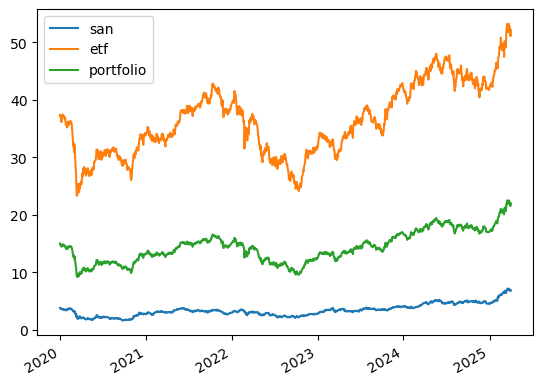

In [154]:
df.plot()

In [84]:
ret = pd.DataFrame({
'Annual returns': [
    (1 + df.san.pct_change().dropna()).prod() ** (252 / (df.shape[0]-1))-1,
    (1 + df.etf.pct_change().dropna()).prod() ** (252 / (df.shape[0]-1))-1,
    (1 + df.portfolio.pct_change().dropna()).prod() ** (252 / (df.shape[0]-1))-1]},
    index = df.columns)
san_ret = ret.loc['san'].values[0]
etf_ret = ret.loc['etf'].values[0]
ret

,Annual returns
san,0.118074
etf,0.063853
portfolio,0.073798


In [92]:
cov_matrix = df[['san', 'etf']].pct_change().dropna().cov() * 252
san_var = cov_matrix.iloc[0, 0]
etf_var = cov_matrix.iloc[1, 1]
cov = cov_matrix.iloc[0, 1]
cov_matrix

,san,etf
san,0.154727,0.038790
etf,0.038790,0.055912


In [104]:
port_vol = np.sqrt(weights @ cov_matrix @ weights.T) * 252**.5
port_vol

4.820737160913232

In [83]:
port_ret = ret.loc['portfolio'].values[0]
port_ret

0.07379802608396946

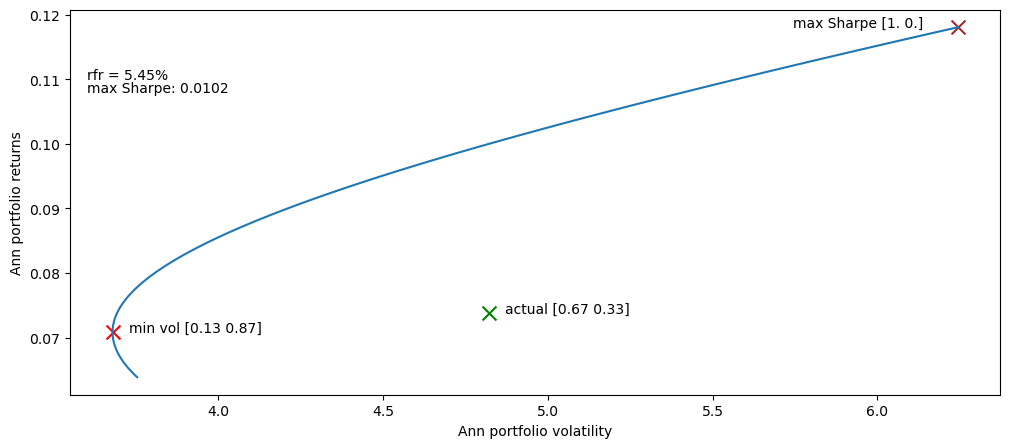

In [161]:
rfr = 0.0545
max_sharpe = 0
sharpe_indx = None
ws = np.stack((np.arange(0, 1.01, 0.01), 1-np.arange(0, 1.01, 0.01)), axis=1)
sigmas, returns = np.zeros(ws.shape[0]), np.zeros(ws.shape[0])
for i in range(ws.shape[0]):
    sigmas[i] = np.sqrt(ws[i] @ cov_matrix @ ws[i].T) * 252**.5
    returns[i] = ws[i] @ np.array([san_ret, etf_ret])
    sharpe = (returns[i] - rfr) / sigmas[i]
    if sharpe > max_sharpe:
        sharpe_indx = i
        max_sharpe = sharpe
    

plt.figure(figsize=(12, 5))
plt.plot(sigmas, returns)
plt.scatter(port_vol, port_ret, marker='x', c='green', s=100)
plt.text(port_vol+.05, port_ret, f'actual {np.round(weights,2)}')
plt.scatter(sigmas[np.argmin(sigmas)], returns[np.argmin(sigmas)], marker='x', c='red', s=100)
if sharpe_indx:
    plt.scatter(sigmas[sharpe_indx], returns[sharpe_indx], marker='x', c='brown', s=100)
    plt.text(3.6, 0.108, f'max Sharpe: {round(max_sharpe,4)}')
    plt.text(sigmas[sharpe_indx]-.5, returns[sharpe_indx], f'max Sharpe {ws[sharpe_indx]}')
plt.text(sigmas[np.argmin(sigmas)]+0.05, returns[np.argmin(sigmas)], f'min vol {ws[np.argmin(sigmas)]}')
plt.text(3.6, 0.11, f'rfr = {rfr*100}%')
plt.xlabel('Ann portfolio volatility')
plt.ylabel('Ann portfolio returns');